## COVID-19 Case Growth Rates are Declining

While the number of COVID-19 cases is increasing in most regions, the rate of increase is slowing, suggesting that eforts to control the spread of the virus are working. 


In [1]:
import sys
# Install required packages
#!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import  linear_model
sns.set(color_codes=True)

In [11]:
pkg = mp.open_package('http://library.metatab.org/jhu.edu-covid19.csv')


Perhaps the most popular image of the COVID-19 crisis is the semi-log cumulative cases chart from the Financial Times, which shows the growth of COVID-19 cases, by region, with a logarithmic Y axis. Recent version include lines for specific growth rates, and annotations for important events. 

<img src="https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F2c0da71c-6e12-11ea-89df-41bea055720b?fit=scale-down&quality=highest&source=next&width=800"/>


In [3]:
confirmed_df = pkg.resource('confirmed').dataframe()


We will reproduce that chart, then show some other views to answer a particularly interesting question: when will each region have its first day of zero new cases?. Here is the re-produced chart, using a [processed version of the Johns Hopkins dataset](https://data.sandiegodata.org/dataset/jhu-edu-covid19/) from the [San Diego Regional Data Library](https://www.sandiegodata.org/). 

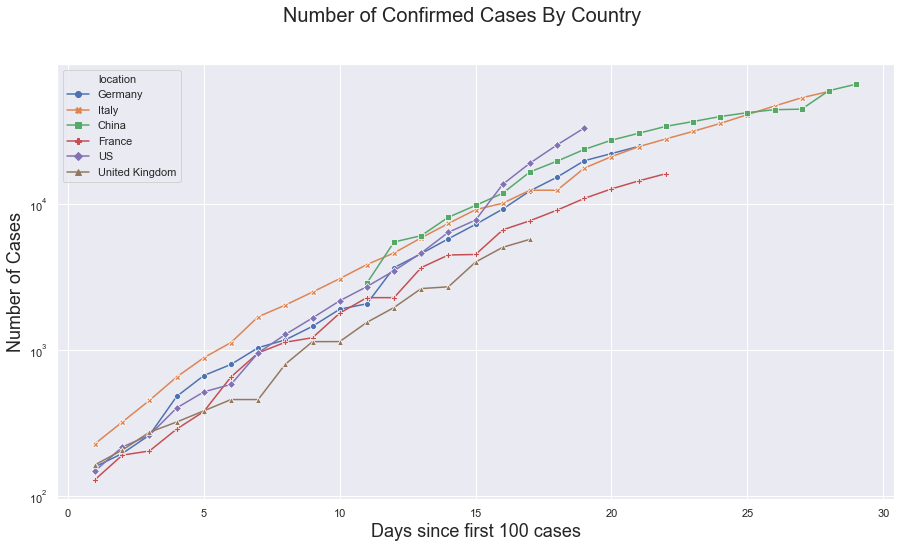

In [4]:

t = confirmed_df[(confirmed_df.days_100 > 0) & (confirmed_df.days_100 < 30) ]
t = t[t.location.isin( ['Italy','US','Germany','France', 'United Kingdom','China'])]

fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Number of Confirmed Cases By Country', fontsize=20)

sns.lineplot(ax=ax, x='days_100',y='confirmed', data=t, hue='location', style='location', ci=None,dashes=False, markers=True)
ax.set_xlabel('Days since first 100 cases', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)
ax.set_yscale('log')

The Financial Times chart shows dashed black lines for the const rate of growth line, such as "CASES DOUBLE EVERY DAY" and "...EVERY THREE DAYS", but it is also evident that the growth curves for the countries are not straight; they bend down. This means that the growth rate is decreasing: if the number of cases today is 33% more than the number of cases yesterday, it may only be 31% more than today tomorrow. If that reduction continues, eventually the number of new cases per day will be zero, an event that signals we are near the end of the worst of the pandemic. 

In [5]:
def plot_growth_reg_100(t, y_col, ax = None, subtitle=''):
    
    x = t.days_100.values.reshape(len(t), 1)
    y = t[y_col].values.reshape(len(t), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
        fig.suptitle('Growth Rate in Confirmed Cases, Trailing 5 days' +("\n"+subtitle if subtitle else ''),
                 fontsize=20)

    sns.scatterplot(ax=ax, x='days_100',y=y_col, data=t, hue='location', ci=None)
    ax.plot(x, regr.predict(x), color='blue', linewidth=3)

    ax.set_xlabel('Days Since 100 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

    plt.gcf().text(.45,0, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)
    print("Correlation:", t.days_100.corr(t.rate_t5d))

    m = regr.coef_[0][0]
    b = regr.intercept_[0]
  
    print(f"Zero growth at {-b/m} days")
    
    return fig, ax

A scatter plot of the growth rates of a selection of the US states in the Johns Hopkins dataset shows that the growth rate is declining over time, and the average predicted date for US states to reach a zero growth rate is 27 days past the date that the region hit 100 cases. 

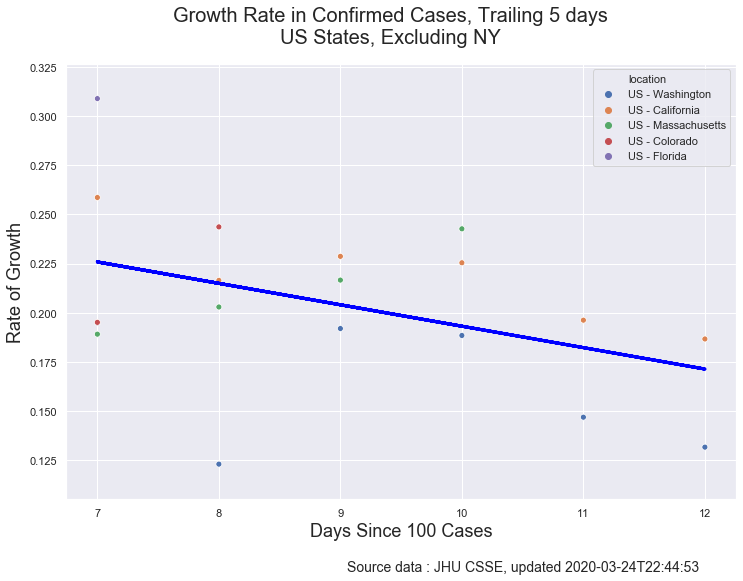

Coefficients: [[-0.01090421]] [0.30213869]
Correlation: -0.42604164248647525
Zero growth at 27.708445080083987 days


In [12]:
t = confirmed_df[(confirmed_df.days_100<30) & (confirmed_df.days_100>=7)] 

t = t[(t.country == 'US') & (~t.location.isin(['US', 'US - New York'])) ]

plot_growth_reg_100(t, 'rate_t5d', subtitle='US States, Excluding NY');


There are some exceptions to this prediction, as the use of the term "selection of states" would indicate: the growth rate for New York is headed in the wrong direction. 

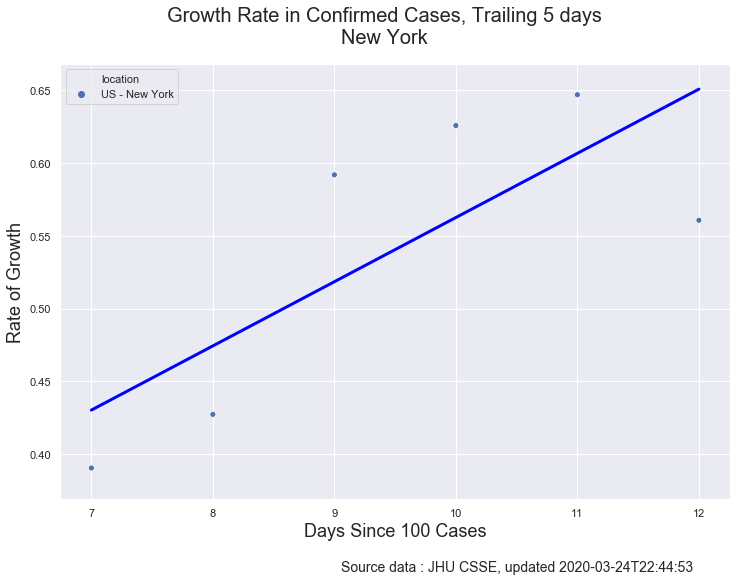

Coefficients: [[0.04404432]] [0.12205496]
Correlation: 0.7730898207658135
Zero growth at -2.7711850888280556 days


In [7]:
t = confirmed_df[(confirmed_df.days_100<30) & (confirmed_df.days_100>=7)] 

t = t[(t.country == 'US') & (t.location.isin(['US - New York'])) ]

plot_growth_reg_100(t, 'rate_t5d', subtitle='New York');


New York's growth rate will eventually turn around, but it is likely that the state will hit zero cases per day much later than other US states. 

Italy's growth rate is also declining, but since Italy was hit earlier, and harder, the predicted Zero Day is day 46, April 8


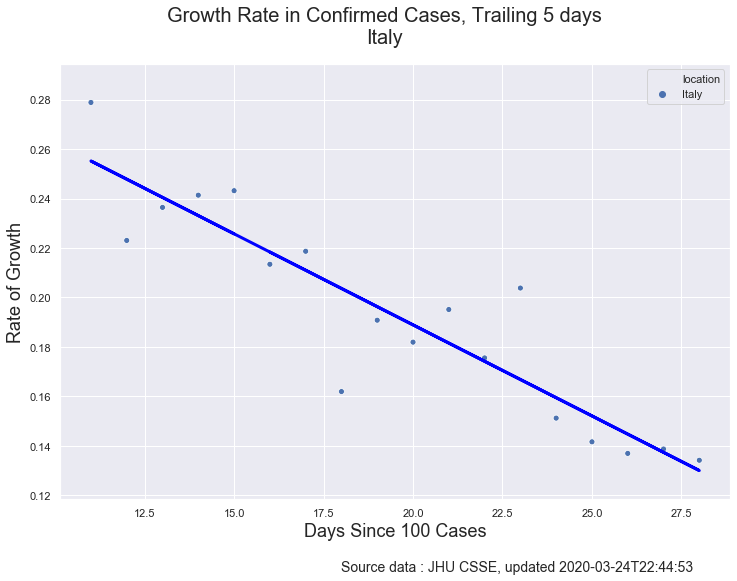

Coefficients: [[-0.00735967]] [0.33612755]
Correlation: -0.9125688026269073
Zero growth at 45.671581017989006 days


In [8]:
t = confirmed_df[(confirmed_df.days_100<40) & (confirmed_df.days_100>10)] 
t = t[t.location.isin( ['Italy'])]

plot_growth_reg_100(t,'rate_t5d', subtitle='Italy');


In [9]:
#confirmed_df[confirmed_df.location.isin( ['US - California'])].date_100.min()+ pd.Timedelta(days=28)

California, however, responded to the pandemic quickly and vigorously, so the growth rate is declining more quickly, with a predicted Zero Day of day 28, April 7. 

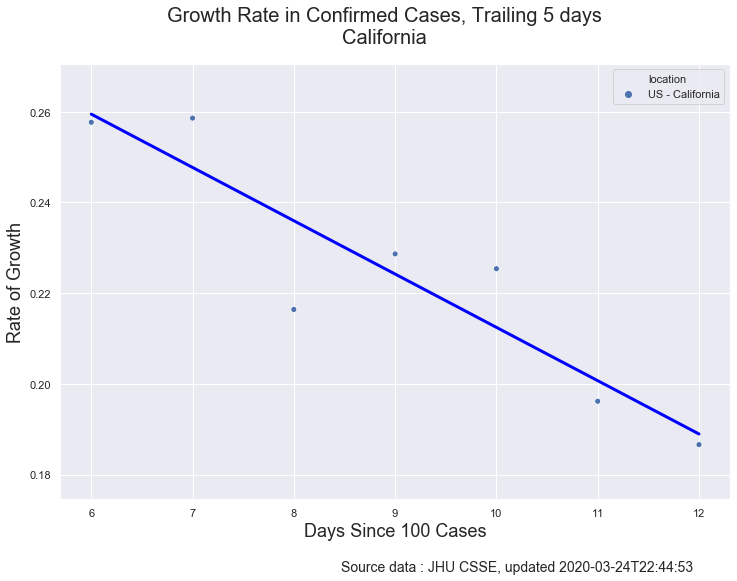

Coefficients: [[-0.01175759]] [0.33003677]
Correlation: -0.9184852580146198
Zero growth at 28.070095897523526 days


In [10]:
t = confirmed_df[(confirmed_df.days_100<40) & (confirmed_df.days_100>5)] 
t = t[t.location.isin( ['US - California'])]

plot_growth_reg_100(t,'rate_t5d', subtitle='California');

The declining growth rates are very good news, and indication that efforts to reduce the spread of the virus are working. The first Zero Days in each region will not mark the end of restrictions on movement, but they are an indication that a return to normalcy is not far away.  